## 1. Descripción del corpus

Librerias

In [27]:
# Librerias
import os
import re
import nltk
import ftfy
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter, defaultdict
from nltk.corpus import stopwords

In [51]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/diego23/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Número de documentos, tokens y vocabulario.

In [2]:
# Configuracion
csv_path = "../data/raw/MeIA_2025_train.csv"
text_col = "Review"
classes = ["Polarity", "Town", "Region", "Type"]

# Cargamos el dataset y elegimos codificacion
df = pd.read_csv(csv_path, encoding='utf-8')

# Limpiamos un poco
df = df.dropna(subset=[text_col])                 # Elimina valores NaN
df = df[df[text_col].str.strip().ne("")]          # Elimina strings vacios
df.reset_index(drop=True, inplace=True)

# Imprimimos resultados
print("Columnas disponibles:", df.columns.tolist())
print("Número de documentos:", len(df))

# Visualizamos el df
df.head()

Columnas disponibles: ['Review', 'Polarity', 'Town', 'Region', 'Type']
Número de documentos: 5000


,Review,Polarity,Town,Region,Type
0,Un Restaurante te invita por su ambiente tan a...,2.0,Tlaquepaque,Jalisco,Restaurant
1,Pagamos 25 pesos por la entrada y no es gran c...,3.0,Bacalar,QuintanaRoo,Attractive
2,Mi esposa y yo nos alojamos en el Dreams por 4...,3.0,Tulum,QuintanaRoo,Hotel
3,"La única decepción puede no ser José Cuervo, p...",2.0,Tequila,Jalisco,Attractive
4,Cuando leí los comentarios sobre cómo son las ...,1.0,Isla_Mujeres,QuintanaRoo,Hotel


In [3]:
# Contamos los mojibakes "Ã"
count_before = df[text_col].astype(str).str.count("Ã").sum()
print(f"Número de 'Ã' antes de ftfy: {count_before}")

# Aplicamos ftfy
df["Review_clean"] = df[text_col].apply(ftfy.fix_text)

# Contamos de nuevo después
count_after = df["Review_clean"].astype(str).str.count("Ã").sum()
print(f"Número de 'Ã' después de ftfy: {count_after}")

# Removemos casos tipo "...Mas" al final del texto por scrapeo
def remove_scrape_artifacts(text: str):
    if not isinstance(text, str):
        return text
    return re.sub(r"Más[\s\W]*$", "", text)
# Aplicamos
df["Review_clean"] = df["Review_clean"].apply(remove_scrape_artifacts)

# Verificamos
examples_after = df[df["Review_clean"].str.contains(r"\.\.\..*Mas", na=False)]
print("Ejemplos de artefactos restantes después de limpiar:", len(examples_after))

Número de 'Ã' antes de ftfy: 731
Número de 'Ã' después de ftfy: 0
Ejemplos de artefactos restantes después de limpiar: 3


In [ ]:
# Creamos una expresion regular para tokenizar palabras en español
WORD_RE = re.compile(r"[A-Za-zÁÉÍÓÚÜÑáéíóúüñ]+(?:[-'][A-Za-zÁÉÍÓÚÜÑáéíóúüñ]+)?")

# Realizamos la tokenizacion
def tokenize(text: str):
    if not isinstance(text, str):
        return []
    text = text.lower()  # Pasamos a minúsculas
    return WORD_RE.findall(text)

# Aplicamos tokenización sobre la columna limpia
df["tokens"] = df["Review_clean"].apply(tokenize)
df["n_tokens"] = df["tokens"].apply(len)

# Contamos tokens en todo el corpus
token_counts = Counter()
for toks in df["tokens"]:
    token_counts.update(toks)

# Total de tokens (con repeticiones)
total_tokens = sum(token_counts.values())

# Vocabulario (palabras únicas)
vocab_size = len(token_counts)

print(f"Total de tokens en el corpus: {total_tokens}")
print(f"Tamaño del vocabulario: {vocab_size}")

Total de tokens en el corpus: 348935
Tamaño del vocabulario: 19517


Hapax legomena y su proporción.

In [5]:
# Hapax = términos con frecuencia 1
hapax_list = [t for t, c in token_counts.items() if c == 1]
hapax_count = len(hapax_list)

# Proporción de hapax sobre vocabulario (qué fracción del vocab son hapax)
hapax_prop_over_vocab = hapax_count / max(len(token_counts), 1)

# Proporción de hapax sobre tokens (qué fracción de todos los tokens son hapax)
hapax_prop_over_tokens = hapax_count / max(total_tokens, 1)

print(f"Hapax (freq=1): {hapax_count}")
print(f"Proporción hapax / vocabulario: {hapax_prop_over_vocab:.4f}")
print(f"Proporción hapax / tokens: {hapax_prop_over_tokens:.4f}")

# (Opcional) Ver algunos ejemplos de hapax
pd.Series(hapax_list[:20], name="Ejemplos de hapax (20)").to_frame()

Hapax (freq=1): 9957
Proporción hapax / vocabulario: 0.5102
Proporción hapax / tokens: 0.0285


,Ejemplos de hapax (20)
0,apuran
1,descuidaron
2,pesas
3,frustrado
4,acanalado
5,elástico
6,ceñir
7,púrpura
8,cintura
9,blye


Porcentaje de stopwords.

In [6]:
# Lista de stopwords en español
stopwords_es = set(stopwords.words("spanish"))

# Función para detectar stopwords
def is_stopword(tok: str):
    return tok in stopwords_es

# Contamos stopwords en cada documento
df["stop_tokens"] = df["tokens"].apply(lambda toks: [t for t in toks if is_stopword(t)])
df["n_stop"] = df["stop_tokens"].apply(len)

# Totales
total_stop = df["n_stop"].sum()
stopword_pct = (total_stop / total_tokens) * 100

print(f"Total de stopwords en el corpus: {total_stop}")
print(f"Porcentaje de stopwords sobre tokens: {stopword_pct:.2f}%")


Total de stopwords en el corpus: 175571
Porcentaje de stopwords sobre tokens: 50.32%


Estadı́sticas por clase (número de documentos, tokens y vocabulario).

In [ ]:
present_cols = [c for c in classes if c in df.columns]

def per_group_stats(group_df: pd.DataFrame) -> pd.Series:
    # n_docs
    n_docs = len(group_df)
    # n_tokens y vocab del grupo
    counter = Counter()
    for toks in group_df["tokens"]:
        counter.update(toks)
    n_tokens = sum(counter.values())
    vocab_size = len(counter)
    return pd.Series({"n_docs": n_docs, "n_tokens": n_tokens, "vocab_size": vocab_size})

# Aplicar a cada columna de clase presente
stats_list = []
for col in present_cols:
    stats = (
        df.groupby(col, dropna=False)
          .apply(per_group_stats, include_groups=False)
          .reset_index()
          .rename(columns={col: "class_value"})
          .assign(class_col=col)  # para saber de qué columna viene
          .loc[:, ["class_col", "class_value", "n_docs", "n_tokens", "vocab_size"]]
    )
    stats_list.append(stats)

stats_per_class = pd.concat(stats_list, ignore_index=True)

# Mostrar resultados
stats_per_class.head(20)


,class_col,class_value,n_docs,n_tokens,vocab_size
0,Polarity,1.0,800,61908,7670
1,Polarity,2.0,900,74973,8421
2,Polarity,3.0,1000,69431,7594
3,Polarity,4.0,1100,68641,7319
4,Polarity,5.0,1200,73982,8304
5,Town,Ajijic,102,7361,1900
6,Town,Atlixco,48,3355,1172
7,Town,Bacalar,250,13449,2685
8,Town,Bernal,58,3055,1013
9,Town,Chiapa_de_Corzo,30,2243,818


In [56]:
# Guardamos estadísticas por clase en processed
output_path = "../data/processed/stats_per_class.csv"
stats_per_class.to_csv(output_path, index=False)
print(f"Archivo guardado en: {output_path}")

Archivo guardado en: ../data/processed/stats_per_class.csv


## 2. Ley de Zipf 

 Calcula la frecuencia absoluta $f(w)$ de cada palabra $w$ en el corpus y ordénalas de mayor a menor. A cada palabra asi ordenada se le asigna un rango $r$, donde $r = 1$ corresponde a la palabra más frecuente, $r = 2$ a la segunda, y asi sucesivamente.

In [ ]:
# Contamos frecuencias absolutas f(w)
token_counts = Counter()
for toks in df["tokens"]:
    token_counts.update(toks)

# Pasamos a un df y ordenamos de mayor a menor
freq_df = (
    pd.DataFrame(token_counts.items(), columns=["token", "freq"])
      .sort_values(["freq", "token"], ascending=[False, True])  # Desempate alfabético
      .reset_index(drop=True)
)

# Asignamos rango r (1 = más frecuente)
freq_df["rank"] = np.arange(1, len(freq_df) + 1)

# Agregamos columnas log
freq_df["log_rank"] = np.log(freq_df["rank"])
freq_df["log_freq"] = np.log(freq_df["freq"])

# Mostramos lo obtenido
freq_df.head(20)

,token,freq,rank,log_rank,log_freq
0,de,15254,1,0.000000,9.632597
1,y,12492,2,0.693147,9.432844
2,la,12429,3,1.098612,9.427788
3,el,10444,4,1.386294,9.253783
4,que,10297,5,1.609438,9.239608
5,en,8436,6,1.791759,9.040264
6,es,5972,7,1.945910,8.694837
7,no,5930,8,2.079442,8.687779
8,a,5512,9,2.197225,8.614683
9,un,5441,10,2.302585,8.601718


Representa gráficamente la relación entre log-rango y log-frecuencia. Es decir, para cada palabra graficar el punto $(\log r, \log f (w))$. La Ley de Zipf predice que los puntos deberı́an aproximarse a una lı́nea recta decreciente.

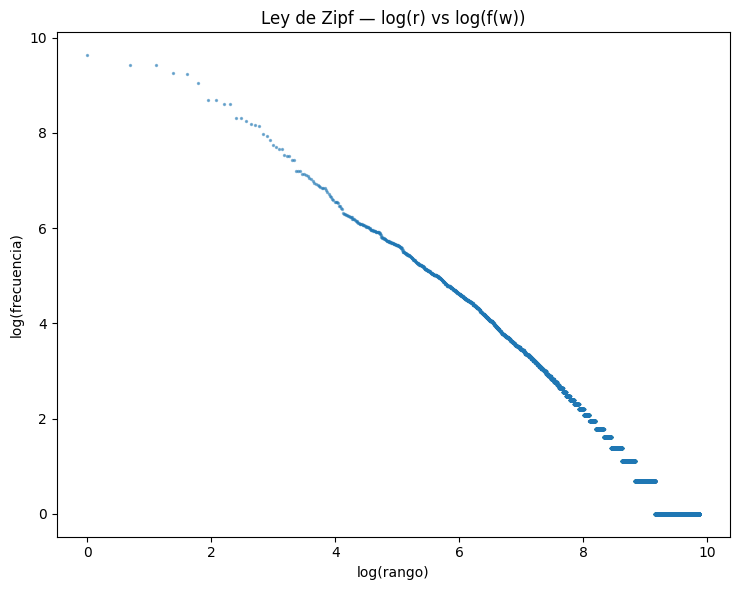

In [12]:
# Asegura carpeta de salida
os.makedirs("../data/processed", exist_ok=True)

# Dispersión completa
plt.figure(figsize=(7.5, 6))
plt.scatter(
    freq_df["log_rank"].values,
    freq_df["log_freq"].values,
    s=2, alpha=0.5, rasterized=True
)
plt.xlabel("log(rango)")
plt.ylabel("log(frecuencia)")
plt.title("Ley de Zipf — log(r) vs log(f(w))")
plt.tight_layout()
plt.savefig("../reports/figures/zipf_loglog_scatter.png", dpi=200)
plt.show()

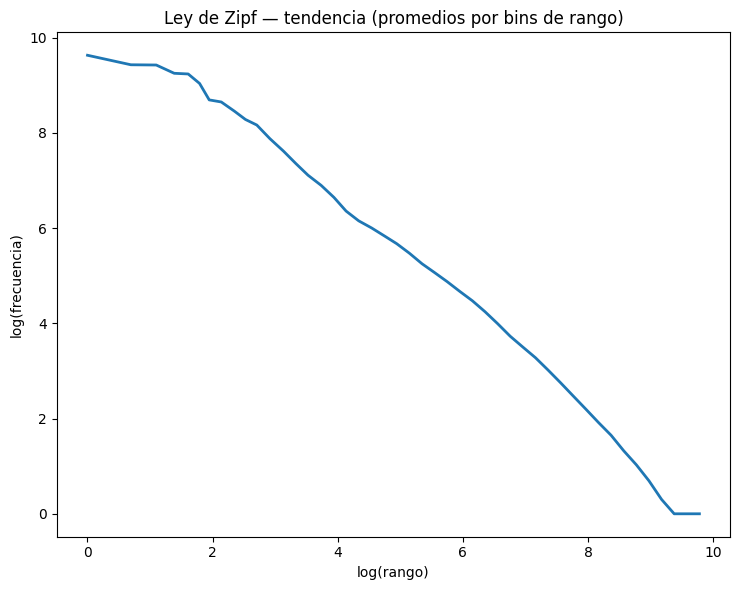

Figuras guardadas en:
 - ../data/processed/zipf_loglog_scatter.png
 - ../data/processed/zipf_loglog_binned.png


In [13]:
# Curva suavizada por bins logarítmicos de rango
bins = np.logspace(np.log10(1), np.log10(len(freq_df)), num=50)
bin_ids = np.digitize(freq_df["rank"].values, bins)

avg_log_r, avg_log_f = [], []
for b in range(1, len(bins)):
    mask = bin_ids == b
    if np.any(mask):
        avg_log_r.append(freq_df.loc[mask, "log_rank"].mean())
        avg_log_f.append(freq_df.loc[mask, "log_freq"].mean())

plt.figure(figsize=(7.5, 6))
plt.plot(avg_log_r, avg_log_f, linewidth=2)
plt.xlabel("log(rango)")
plt.ylabel("log(frecuencia)")
plt.title("Ley de Zipf — tendencia (promedios por bins de rango)")
plt.tight_layout()
plt.savefig("../reports/figures/zipf_loglog_binned.png", dpi=200)
plt.show()

print("Figuras guardadas en:")
print(" - ../data/processed/zipf_loglog_scatter.png")
print(" - ../data/processed/zipf_loglog_binned.png")

Ajusta una recta mediante regresión lineal sobre los puntos $(\log r, \log f(w))$, de la forma:

$$ \log f(r) = \log C - s \cdot \log r, $$

lo cual equivale al modelo Zipfiano $f(r) \approx \frac{C}{r^{s}}$.

Ajuste (FULL):
  s = 1.2706
  C = 1.9739e+05
  R^2 = 0.9729


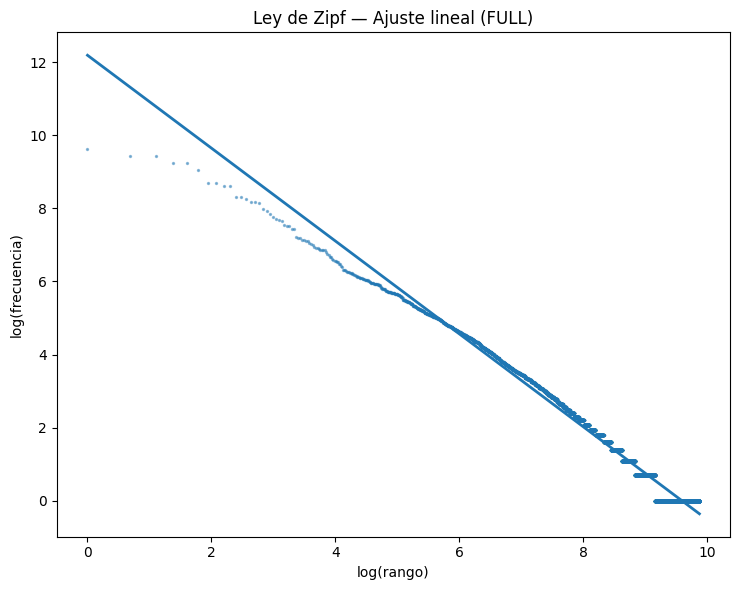


Ajuste (MIDDLE 5–95%):
  s = 1.3373
  C = 3.5350e+05
  R^2 = 0.9586


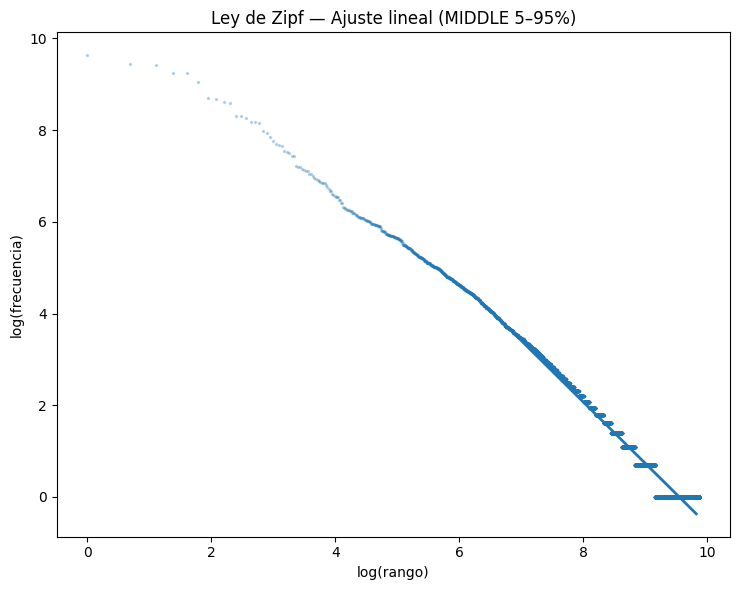

In [14]:
# Asegúrate de tener freq_df con columnas: rank, freq, log_rank, log_freq
x = freq_df["log_rank"].values
y = freq_df["log_freq"].values

def linfit_and_report(x, y):
    # Ajuste lineal: y = a x + b
    a, b = np.polyfit(x, y, deg=1)
    y_hat = a * x + b
    ss_res = np.sum((y - y_hat)**2)
    ss_tot = np.sum((y - y.mean())**2)
    r2 = 1 - ss_res/ss_tot

    # Parámetros Zipf
    s = -a                   # pendiente negativa => s > 0
    C = float(np.exp(b))     # log C = b

    return dict(a=float(a), b=float(b), s=float(s), C=C, r2=float(r2)), y_hat

# ---------- (1) Full fit ----------
full_stats, y_full = linfit_and_report(x, y)
print("Ajuste (FULL):")
print(f"  s = {full_stats['s']:.4f}")
print(f"  C = {full_stats['C']:.4e}")
print(f"  R^2 = {full_stats['r2']:.4f}")

plt.figure(figsize=(7.5, 6))
plt.scatter(x, y, s=2, alpha=0.45, rasterized=True)
# línea ajustada ordenada por x para que se vea continua
idx = np.argsort(x)
plt.plot(x[idx], np.array(y_full)[idx], linewidth=2)
plt.xlabel("log(rango)")
plt.ylabel("log(frecuencia)")
plt.title("Ley de Zipf — Ajuste lineal (FULL)")
plt.tight_layout()
fig_full_path = "../reports/figures/zipf_fit_full.png"
plt.savefig(fig_full_path, dpi=200)
plt.show()

# ---------- (2) Middle fit (robusto: 5–95% por rango) ----------
low_q, high_q = np.quantile(freq_df["rank"].values, [0.05, 0.95])
mask_mid = (freq_df["rank"].values >= low_q) & (freq_df["rank"].values <= high_q)
mid_stats, y_mid = linfit_and_report(x[mask_mid], y[mask_mid])
print("\nAjuste (MIDDLE 5–95%):")
print(f"  s = {mid_stats['s']:.4f}")
print(f"  C = {mid_stats['C']:.4e}")
print(f"  R^2 = {mid_stats['r2']:.4f}")

plt.figure(figsize=(7.5, 6))
plt.scatter(x, y, s=2, alpha=0.25, rasterized=True)
# dibujamos recta sólo sobre el tramo medio
x_mid_sorted = np.sort(x[mask_mid])
y_mid_line = mid_stats["a"] * x_mid_sorted + mid_stats["b"]
plt.plot(x_mid_sorted, y_mid_line, linewidth=2)
plt.xlabel("log(rango)")
plt.ylabel("log(frecuencia)")
plt.title("Ley de Zipf — Ajuste lineal (MIDDLE 5–95%)")
plt.tight_layout()
fig_mid_path = "../reports/figures/zipf_fit_middle.png"
plt.savefig(fig_mid_path, dpi=200)
plt.show()


En esta formulación:

* $C$ es una **constante de normalización** que se aproxima a la frecuencia de la palabra más común ($f(1) \approx C$). 
* $s$ es el **exponente de Zipf**, que controla la rapidez con que decrecen las frecuencias conforme aumenta el rango. Valores cercanos a $s \approx 1$ son típicos en lenguajes naturales. 

In [15]:
def resumen_zipf(nombre, stats, freq_df):
    s = stats["s"]
    C = stats["C"]
    r2 = stats["r2"]

    # Frecuencia de la palabra más común (r=1)
    f1 = int(freq_df.loc[0, "freq"])
    err_abs = abs(C - f1)
    err_rel = err_abs / f1 * 100

    print(f"\n[{nombre}]")
    print(f"  s (pendiente con signo cambiado) = {s:.4f}")
    print(f"  C (exp(intercept))              = {C:.2f}")
    print(f"  R^2 del ajuste                  = {r2:.4f}")
    print(f"  f(1) real (token más frecuente) = {f1}")
    print(f"  |C - f(1)|                      = {err_abs:.2f}  ({err_rel:.2f}%)")

resumen_zipf("FULL", full_stats, freq_df)
resumen_zipf("MIDDLE 5–95%", mid_stats, freq_df)


[FULL]
  s (pendiente con signo cambiado) = 1.2706
  C (exp(intercept))              = 197393.45
  R^2 del ajuste                  = 0.9729
  f(1) real (token más frecuente) = 15254
  |C - f(1)|                      = 182139.45  (1194.04%)

[MIDDLE 5–95%]
  s (pendiente con signo cambiado) = 1.3373
  C (exp(intercept))              = 353496.22
  R^2 del ajuste                  = 0.9586
  f(1) real (token más frecuente) = 15254
  |C - f(1)|                      = 338242.22  (2217.40%)


Ajuste (intercepto fijado en log f(1), tramo medio y f>=2):
  s = 0.9630
  C = f(1) = 15254
  R^2 = 0.8935


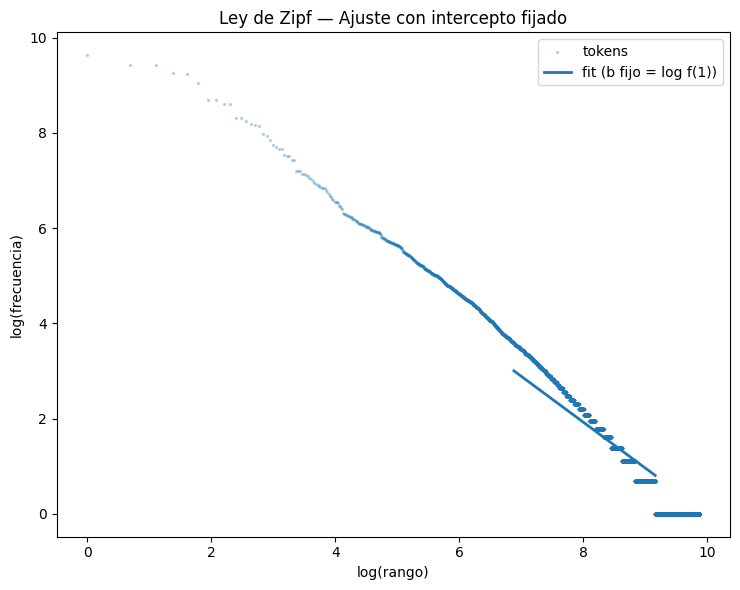

In [16]:
x = freq_df["log_rank"].values
y = freq_df["log_freq"].values

# Frecuencia de la palabra más común (r=1)
f1 = float(freq_df.loc[0, "freq"])
b0 = np.log(f1)             # fijamos log C = log f(1)

# Máscara "robusta": 5–95% de rangos y solo frecuencias >= 2
r = freq_df["rank"].values
mask_mid = (r >= np.quantile(r, 0.05)) & (r <= np.quantile(r, 0.95))
mask_freq = freq_df["freq"].values >= 2
mask = mask_mid & mask_freq

xm, ym = x[mask], y[mask]

# OLS con intercepto fijo: y = b0 + a x  ->  minimiza ||(y - b0) - a x||
# Cerrado: a = (x^T (y - b0)) / (x^T x)
a_fixed = (xm @ (ym - b0)) / (xm @ xm)
s_fixed = -a_fixed

# R^2 con intercepto fijo
yhat = b0 + a_fixed * xm
ss_res = np.sum((ym - yhat)**2)
ss_tot = np.sum((ym - ym.mean())**2)
r2_fixed = 1 - ss_res/ss_tot

print("Ajuste (intercepto fijado en log f(1), tramo medio y f>=2):")
print(f"  s = {s_fixed:.4f}")
print(f"  C = f(1) = {int(f1)}")
print(f"  R^2 = {r2_fixed:.4f}")

# Figura comparando: puntos + recta con intercepto fijo
plt.figure(figsize=(7.5, 6))
plt.scatter(x, y, s=2, alpha=0.25, rasterized=True, label="tokens")
x_line = np.linspace(xm.min(), xm.max(), 200)
y_line = b0 + a_fixed * x_line
plt.plot(x_line, y_line, linewidth=2, label="fit (b fijo = log f(1))")
plt.xlabel("log(rango)")
plt.ylabel("log(frecuencia)")
plt.title("Ley de Zipf — Ajuste con intercepto fijado")
plt.legend()
plt.tight_layout()
plt.savefig("../reports/figures/zipf_fit_fixed_intercept.png", dpi=200)
plt.show()

## 3. Palabras importantes por clase

Elimina palabras vacı́as y normaliza el texto.

In [17]:
# Usamos la lista de stopwords que ya definimos con nltk
def clean_tokens(toks):
    return [t for t in toks if t not in stopwords_es]

# Nueva columna: tokens normalizados
df["tokens_clean"] = df["tokens"].apply(clean_tokens)
df["n_tokens_clean"] = df["tokens_clean"].apply(len)

# Ejemplo: primeras reseñas antes y después
df[["tokens", "tokens_clean", "n_tokens", "n_tokens_clean"]].head(10)

,tokens,tokens_clean,n_tokens,n_tokens_clean
0,"[un, restaurante, te, invita, por, su, ambient...","[restaurante, invita, ambiente, tan, alegre, s...",46,21
1,"[pagamos, pesos, por, la, entrada, y, no, es, ...","[pagamos, pesos, entrada, gran, cosa, único, b...",32,15
2,"[mi, esposa, y, yo, nos, alojamos, en, el, dre...","[esposa, alojamos, dreams, días, enero, primer...",134,62
3,"[la, única, decepción, puede, no, ser, josé, c...","[única, decepción, puede, ser, josé, cuervo, r...",181,88
4,"[cuando, leí, los, comentarios, sobre, cómo, s...","[leí, comentarios, cómo, cosas, grosero, creen...",117,58
5,"[durante, la, cata, compre, una, botella, de, ...","[cata, compre, botella, tequila, cofradia, rep...",57,30
6,"[la, verdad, muy, costosa, la, entrada, pesos,...","[verdad, costosa, entrada, pesos, mexicanos, p...",55,28
7,"[el, lugar, está, decorado, muy, bonito, tiene...","[lugar, decorado, bonito, mesas, interior, afu...",45,22
8,"[hace, tiempo, que, fui, al, restaurante, de, ...","[hace, tiempo, restaurante, hotel, bonito, agr...",45,17
9,"[primero, de, todo, el, hotel, está, situado, ...","[primero, hotel, situado, buena, ubicación, pe...",140,73


Identifica las palabras más frecuentes en cada clase.

In [18]:
def top_words_per_class(df, class_col, k=20):
    """
    Regresa un DataFrame con las k palabras más frecuentes por cada valor
    de `class_col`, usando la columna df['tokens_clean'].
    """
    if class_col not in df.columns:
        raise ValueError(f"No existe la columna de clase: {class_col}")
    if "tokens_clean" not in df.columns:
        raise ValueError("Falta la columna 'tokens_clean'. Ejecute la limpieza primero.")

    frames = []
    for val, g in df.groupby(class_col, dropna=False):
        c = Counter()
        for toks in g["tokens_clean"]:
            c.update(toks)
        # top-k de esta clase
        topk = c.most_common(k)
        tmp = pd.DataFrame(topk, columns=["token", "freq"])
        tmp.insert(0, "class_col", class_col)
        tmp.insert(1, "class_value", val)
        tmp["rank"] = range(1, len(tmp) + 1)
        frames.append(tmp)

    out = pd.concat(frames, ignore_index=True)
    return out[["class_col", "class_value", "rank", "token", "freq"]]

In [24]:
# Escoge la(s) columna(s) de clase presentes
candidatas = ["Polarity", "Town", "Region", "Type"]
presentes = [c for c in candidatas if c in df.columns]

# Ejemplo 1: top-20 por Polarity (si existe)
if "Town" in presentes:
    top_pol = top_words_per_class(df, "Town", k=20)
    display(top_pol.head(40))  # muestra 2 clases * 20 (si aplica)

# Ejemplo 2: sacar para todas las clases presentes (y visualizar las primeras filas)
tablas_por_clase = {c: top_words_per_class(df, c, k=20) for c in presentes}
for c, tabla in tablas_por_clase.items():
    print(f"\n==== Top palabras por clase: {c} ====")
    display(tabla.head(40))


,class_col,class_value,rank,token,freq
0,Town,Ajijic,1,comida,55
1,Town,Ajijic,2,lugar,42
2,Town,Ajijic,3,servicio,33
3,Town,Ajijic,4,restaurante,30
4,Town,Ajijic,5,buena,25
5,Town,Ajijic,6,hotel,24
6,Town,Ajijic,7,bien,22
7,Town,Ajijic,8,bueno,20
8,Town,Ajijic,9,ajijic,20
9,Town,Ajijic,10,si,19



==== Top palabras por clase: Polarity ====


,class_col,class_value,rank,token,freq
0,Polarity,1.0,1,hotel,385
1,Polarity,1.0,2,lugar,328
2,Polarity,1.0,3,servicio,284
3,Polarity,1.0,4,comida,262
4,Polarity,1.0,5,habitación,250
5,Polarity,1.0,6,si,247
6,Polarity,1.0,7,personal,144
7,Polarity,1.0,8,restaurante,136
8,Polarity,1.0,9,solo,135
9,Polarity,1.0,10,mal,121



==== Top palabras por clase: Town ====


,class_col,class_value,rank,token,freq
0,Town,Ajijic,1,comida,55
1,Town,Ajijic,2,lugar,42
2,Town,Ajijic,3,servicio,33
3,Town,Ajijic,4,restaurante,30
4,Town,Ajijic,5,buena,25
5,Town,Ajijic,6,hotel,24
6,Town,Ajijic,7,bien,22
7,Town,Ajijic,8,bueno,20
8,Town,Ajijic,9,ajijic,20
9,Town,Ajijic,10,si,19



==== Top palabras por clase: Region ====


,class_col,class_value,rank,token,freq
0,Region,Baja_CaliforniaSur,1,comida,95
1,Region,Baja_CaliforniaSur,2,lugar,92
2,Region,Baja_CaliforniaSur,3,servicio,60
3,Region,Baja_CaliforniaSur,4,hotel,50
4,Region,Baja_CaliforniaSur,5,buena,47
5,Region,Baja_CaliforniaSur,6,si,46
6,Region,Baja_CaliforniaSur,7,restaurante,41
7,Region,Baja_CaliforniaSur,8,bien,41
8,Region,Baja_CaliforniaSur,9,así,37
9,Region,Baja_CaliforniaSur,10,mejor,33



==== Top palabras por clase: Type ====


,class_col,class_value,rank,token,freq
0,Type,Attractive,1,lugar,649
1,Type,Attractive,2,playa,512
2,Type,Attractive,3,si,498
3,Type,Attractive,4,agua,350
4,Type,Attractive,5,ruinas,327
5,Type,Attractive,6,ver,275
6,Type,Attractive,7,pena,236
7,Type,Attractive,8,cenote,230
8,Type,Attractive,9,así,227
9,Type,Attractive,10,ir,227


Reflexiona si las palabras más repetidas son realmente discriminativas.

In [ ]:
# ===============================================
# Discriminatividad: Log-odds con prior (Monroe)
# ===============================================
from collections import Counter

def log_odds_with_prior(df, class_col, alpha=0.01, topk=20):
    # Conteos por clase y globales
    by_class = {}
    global_counts = Counter()
    for val, g in df.groupby(class_col, dropna=False):
        c = Counter()
        for toks in g["tokens_clean"]:
            c.update(toks)
        by_class[val] = c
        global_counts.update(c)

    V = len(global_counts)
    results = []

    # Precomputos globales
    N_global = sum(global_counts.values())

    for val, c in by_class.items():
        # Conjunto "resto"
        rest = global_counts.copy()
        for w, n in c.items():
            rest[w] -= n
            if rest[w] <= 0:
                del rest[w]

        N_i   = sum(c.values())
        N_rest = sum(rest.values())

        # log-odds y z
        log_odds = {}
        var = {}
        for w in global_counts.keys():
            # suavizado Dirichlet
            pw_i   = (c.get(w,0)   + alpha) / (N_i   + alpha*V)
            pw_rest= (rest.get(w,0)+ alpha) / (N_rest+ alpha*V)
            log_odds[w] = np.log(pw_i/(1-pw_i)) - np.log(pw_rest/(1-pw_rest))
            var[w] = 1/(c.get(w,0)+alpha) + 1/(rest.get(w,0)+alpha)

        z_scores = {w: log_odds[w] / np.sqrt(var[w]) for w in log_odds}
        top = sorted(z_scores.items(), key=lambda x: x[1], reverse=True)[:topk]
        df_top = pd.DataFrame(top, columns=["token","z_log_odds"]).assign(class_col=class_col, class_value=val)
        results.append(df_top)

    out = pd.concat(results, ignore_index=True)
    return out[["class_col","class_value","token","z_log_odds"]]

# Ejemplos:
for col in ["Polarity","Town","Region","Type"]:
    if col in df.columns:
        print(f"\n==== Términos más característicos (log-odds) para {col} ====")
        display(log_odds_with_prior(df, col, alpha=0.01, topk=20))



==== Términos más característicos (log-odds) para Polarity ====


,class_col,class_value,token,z_log_odds
0,Polarity,1.0,peor,11.745673
1,Polarity,1.0,pésimo,10.105375
2,Polarity,1.0,mala,9.878909
3,Polarity,1.0,dijeron,9.510377
4,Polarity,1.0,dijo,8.469117
...,...,...,...,...
95,Polarity,5.0,lugar,5.858828
96,Polarity,5.0,visita,5.833061
97,Polarity,5.0,pronto,5.704584
98,Polarity,5.0,valladolid,5.703923



==== Términos más característicos (log-odds) para Town ====


,class_col,class_value,token,z_log_odds
0,Town,Ajijic,malecón,8.864397
1,Town,Ajijic,b,8.273855
2,Town,Ajijic,lago,7.266801
3,Town,Ajijic,reales,7.052127
4,Town,Ajijic,bistec,6.853088
...,...,...,...,...
795,Town,Zacatlan,chiles,4.451083
796,Town,Zacatlan,parque,4.442875
797,Town,Zacatlan,regular,4.373027
798,Town,Zacatlan,diversas,4.350655



==== Términos más característicos (log-odds) para Region ====


,class_col,class_value,token,z_log_odds
0,Region,Baja_CaliforniaSur,the,7.675120
1,Region,Baja_CaliforniaSur,pescado,7.655387
2,Region,Baja_CaliforniaSur,misión,7.513587
3,Region,Baja_CaliforniaSur,margaritas,6.728010
4,Region,Baja_CaliforniaSur,to,6.466649
...,...,...,...,...
375,Region,Yucatan,fuente,4.817008
376,Region,Yucatan,helado,4.817008
377,Region,Yucatan,xkeken,4.810762
378,Region,Yucatan,pibil,4.440036



==== Términos más característicos (log-odds) para Type ====


,class_col,class_value,token,z_log_odds
0,Type,Attractive,ruinas,17.274695
1,Type,Attractive,playa,15.501880
2,Type,Attractive,ver,14.379228
3,Type,Attractive,entrada,14.354958
4,Type,Attractive,cenote,13.580303
5,Type,Attractive,agua,11.955234
6,Type,Attractive,pena,11.778206
7,Type,Attractive,historia,11.513209
8,Type,Attractive,guía,11.353905
9,Type,Attractive,visita,11.290403


## 4. Patrones gramaticales (POS 4-gramas)

Etiqueta con POS cada documento.

In [28]:
# Carga del modelo de español (asegúrate de descargarlo antes con: python -m spacy download es_core_news_sm)
nlp = spacy.load("es_core_news_sm")

def get_pos_tags(text):
    if not isinstance(text, str):
        return []
    doc = nlp(text)
    return [token.pos_ for token in doc]

# Nueva columna con secuencia de POS por documento
df["pos_seq"] = df["Review_clean"].apply(get_pos_tags)

# Ejemplo de las primeras reseñas con sus POS
for i in range(3):
    print(f"\nDoc {i}:")
    print("Texto:", df["Review_clean"].iloc[i][:200], "...")
    print("POS:", df["pos_seq"].iloc[i][:20])


Doc 0:
Texto: Un Restaurante te invita por su ambiente tan alegre,.pero al sentarte los meseros te apuran al tomar tu orden, y luego al llevarte tu orden se olvidan de ti.
La comida esta buena.
Hay estacionamiento. ...
POS: ['DET', 'PROPN', 'PRON', 'VERB', 'ADP', 'DET', 'NOUN', 'ADV', 'PROPN', 'ADP', 'NOUN', 'DET', 'NOUN', 'PRON', 'VERB', 'ADP', 'VERB', 'DET', 'NOUN', 'PUNCT']

Doc 1:
Texto: Pagamos 25 pesos por la entrada y no es gran cosa. Lo único bueno es que no habia nadie, pero hay lugares mucho mas bonitos para bañarse en la laguna que son gratuitos. ...
POS: ['VERB', 'NUM', 'NOUN', 'ADP', 'DET', 'NOUN', 'CCONJ', 'ADV', 'AUX', 'ADJ', 'NOUN', 'PUNCT', 'PRON', 'ADJ', 'ADJ', 'AUX', 'SCONJ', 'ADV', 'VERB', 'PRON']

Doc 2:
Texto: Mi esposa y yo nos alojamos en el Dreams por 4 días en enero de 2016. Primero tengo que decir que el complejo era muy agradable y las instalaciones parecía muy bien cuidados. Teníamos una habitación c ...
POS: ['DET', 'NOUN', 'CCONJ', 'PRON', 'PRON', 'VERB'

Extrae las secuencias gramaticales más frecuentes de longitud 4 en cada clase.

In [29]:
def extract_pos_ngrams(pos_seq, n=4):
    """Extrae n-gramas de etiquetas POS de una secuencia."""
    return [tuple(pos_seq[i:i+n]) for i in range(len(pos_seq)-n+1)]

# Crear columna con los 4-gramas de cada doc
df["pos_4grams"] = df["pos_seq"].apply(lambda seq: extract_pos_ngrams(seq, n=4))

def top_pos_ngrams_per_class(df, class_col, k=20):
    """Devuelve los k POS 4-gramas más frecuentes por cada valor de class_col."""
    frames = []
    for val, g in df.groupby(class_col, dropna=False):
        c = Counter()
        for ngrams in g["pos_4grams"]:
            c.update(ngrams)
        topk = c.most_common(k)
        tmp = pd.DataFrame(topk, columns=["pos_4gram", "freq"])
        tmp.insert(0, "class_col", class_col)
        tmp.insert(1, "class_value", val)
        tmp["rank"] = range(1, len(tmp)+1)
        frames.append(tmp)
    return pd.concat(frames, ignore_index=True)

# Ejecutamos para todas las columnas de clase presentes
class_cols = [c for c in ["Polarity","Town","Region","Type"] if c in df.columns]

os.makedirs("../reports/tables", exist_ok=True)
pos_ngram_tables = {}
for col in class_cols:
    table = top_pos_ngrams_per_class(df, col, k=20)
    pos_ngram_tables[col] = table
    out_path = f"../reports/tables/top_pos4grams_{col.lower()}.csv"
    table.to_csv(out_path, index=False)
    print(f"Guardado: {out_path}")
    display(table.head(20))

Guardado: ../reports/tables/top_pos4grams_polarity.csv


,class_col,class_value,pos_4gram,freq,rank
0,Polarity,1.0,"(NOUN, ADP, DET, NOUN)",830,1
1,Polarity,1.0,"(ADP, DET, NOUN, PUNCT)",770,2
2,Polarity,1.0,"(DET, NOUN, ADP, NOUN)",690,3
3,Polarity,1.0,"(VERB, ADP, DET, NOUN)",671,4
4,Polarity,1.0,"(ADP, DET, NOUN, ADP)",527,5
5,Polarity,1.0,"(VERB, DET, NOUN, ADP)",500,6
6,Polarity,1.0,"(DET, NOUN, ADP, DET)",492,7
7,Polarity,1.0,"(NOUN, ADP, NOUN, PUNCT)",410,8
8,Polarity,1.0,"(NOUN, PUNCT, DET, NOUN)",398,9
9,Polarity,1.0,"(PRON, VERB, DET, NOUN)",343,10


Guardado: ../reports/tables/top_pos4grams_town.csv


,class_col,class_value,pos_4gram,freq,rank
0,Town,Ajijic,"(ADP, DET, NOUN, PUNCT)",110,1
1,Town,Ajijic,"(NOUN, ADP, DET, NOUN)",99,2
2,Town,Ajijic,"(DET, NOUN, ADP, NOUN)",91,3
3,Town,Ajijic,"(VERB, ADP, DET, NOUN)",72,4
4,Town,Ajijic,"(DET, NOUN, ADP, DET)",67,5
5,Town,Ajijic,"(NOUN, PUNCT, DET, NOUN)",59,6
6,Town,Ajijic,"(ADJ, PUNCT, DET, NOUN)",57,7
7,Town,Ajijic,"(ADP, DET, NOUN, ADP)",56,8
8,Town,Ajijic,"(PUNCT, DET, NOUN, AUX)",56,9
9,Town,Ajijic,"(DET, NOUN, AUX, ADJ)",56,10


Guardado: ../reports/tables/top_pos4grams_region.csv


,class_col,class_value,pos_4gram,freq,rank
0,Region,Baja_CaliforniaSur,"(NOUN, ADP, DET, NOUN)",245,1
1,Region,Baja_CaliforniaSur,"(ADP, DET, NOUN, PUNCT)",222,2
2,Region,Baja_CaliforniaSur,"(DET, NOUN, ADP, NOUN)",190,3
3,Region,Baja_CaliforniaSur,"(ADP, DET, NOUN, ADP)",165,4
4,Region,Baja_CaliforniaSur,"(DET, NOUN, ADP, DET)",159,5
5,Region,Baja_CaliforniaSur,"(VERB, ADP, DET, NOUN)",147,6
6,Region,Baja_CaliforniaSur,"(NOUN, ADP, NOUN, PUNCT)",110,7
7,Region,Baja_CaliforniaSur,"(VERB, DET, NOUN, ADP)",103,8
8,Region,Baja_CaliforniaSur,"(DET, NOUN, AUX, ADJ)",102,9
9,Region,Baja_CaliforniaSur,"(DET, NOUN, ADJ, PUNCT)",99,10


Guardado: ../reports/tables/top_pos4grams_type.csv


,class_col,class_value,pos_4gram,freq,rank
0,Type,Attractive,"(NOUN, ADP, DET, NOUN)",1592,1
1,Type,Attractive,"(ADP, DET, NOUN, PUNCT)",1344,2
2,Type,Attractive,"(DET, NOUN, ADP, NOUN)",1172,3
3,Type,Attractive,"(ADP, DET, NOUN, ADP)",1139,4
4,Type,Attractive,"(VERB, ADP, DET, NOUN)",1121,5
5,Type,Attractive,"(DET, NOUN, ADP, DET)",1012,6
6,Type,Attractive,"(VERB, DET, NOUN, ADP)",765,7
7,Type,Attractive,"(NOUN, ADP, NOUN, PUNCT)",682,8
8,Type,Attractive,"(NOUN, PUNCT, DET, NOUN)",646,9
9,Type,Attractive,"(ADJ, ADP, DET, NOUN)",584,10


Discute si estas estructuras difieren entre clases y explica por qué.

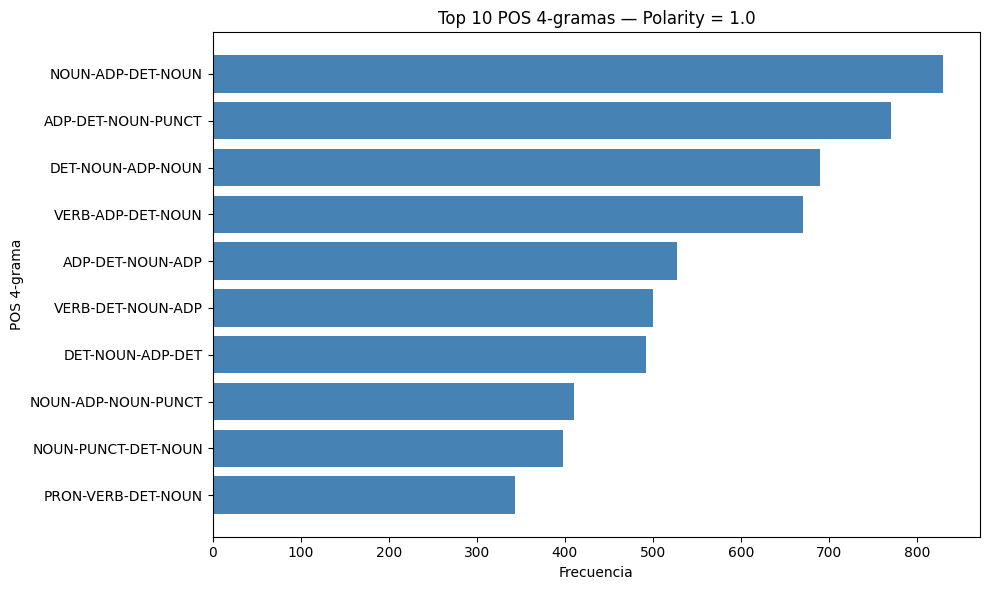

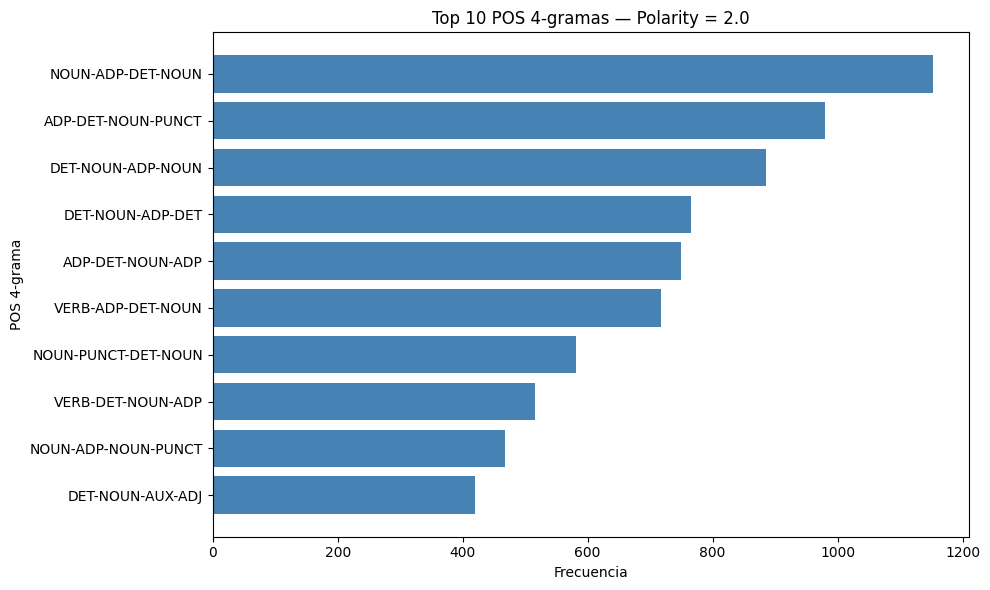

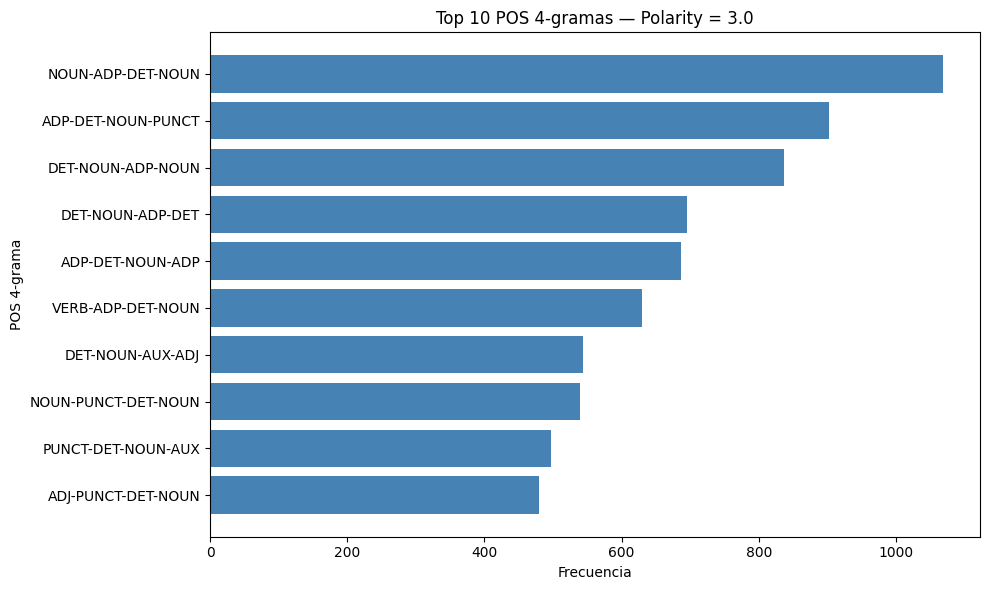

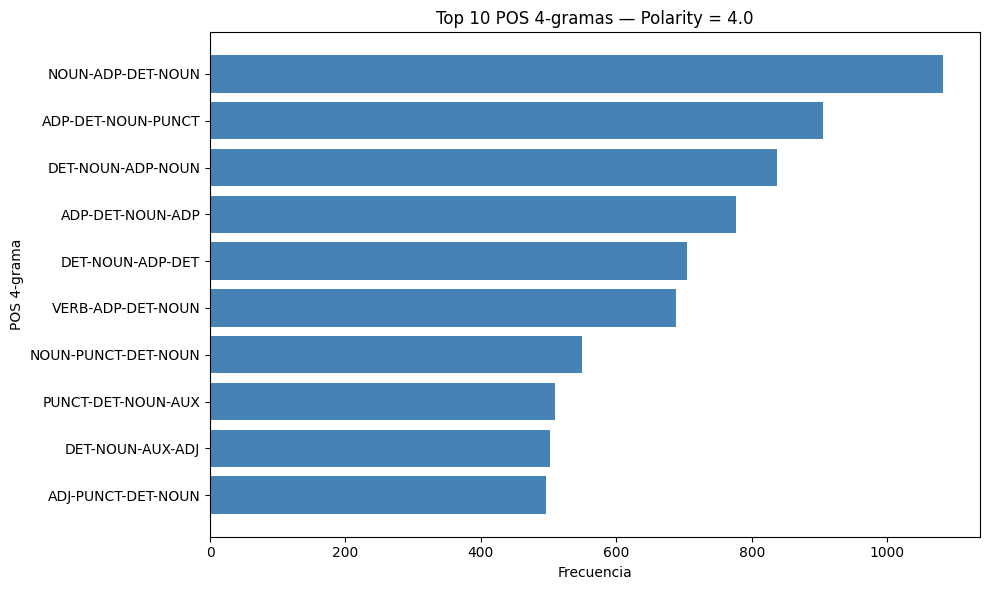

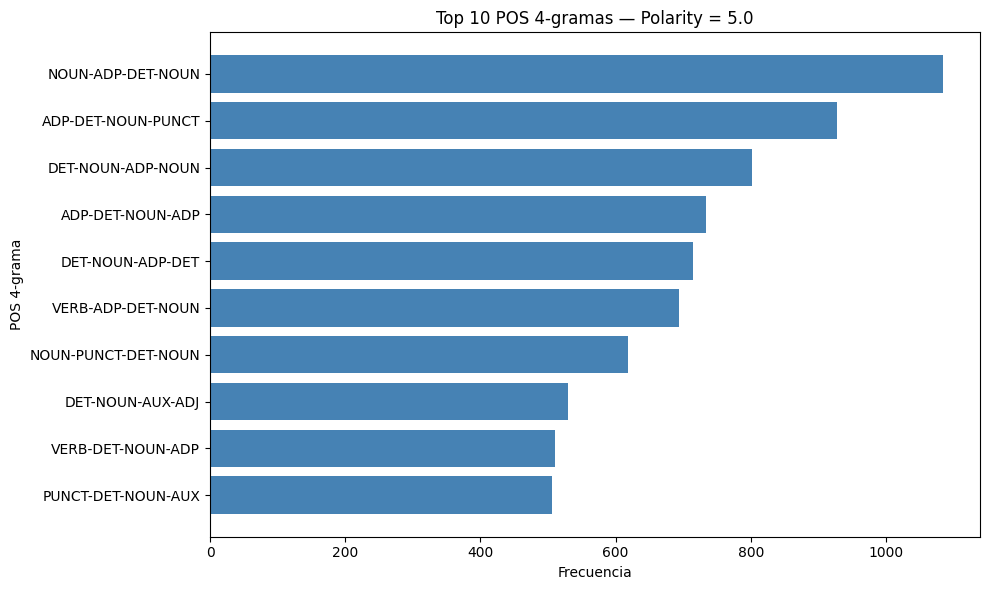

In [ ]:
def plot_top_pos4grams(table, class_col, class_value, topn=10):
    """Grafica los top-n POS 4-gramas más frecuentes de una clase específica."""
    subset = table[(table["class_col"]==class_col) & (table["class_value"]==class_value)].head(topn)

    plt.figure(figsize=(10,6))
    labels = ['-'.join(gram) for gram in subset["pos_4gram"]]
    plt.barh(labels, subset["freq"], color="steelblue")
    plt.xlabel("Frecuencia")
    plt.ylabel("POS 4-grama")
    plt.title(f"Top {topn} POS 4-gramas — {class_col} = {class_value}")
    plt.gca().invert_yaxis()  # para que el más frecuente quede arriba
    plt.tight_layout()
    plt.show()

# Ejemplo: graficar top-10 POS 4-gramas para Polarity=5.0 (si existe)
if "Polarity" in pos_ngram_tables:
    table = pos_ngram_tables["Polarity"]
    for val in table["class_value"].unique():
        plot_top_pos4grams(table, "Polarity", val, topn=10)

# También puedes repetir para "Town", "Region", "Type"
# Ejemplo:
# table = pos_ngram_tables["Type"]
# for val in table["class_value"].unique():
#     plot_top_pos4grams(table, "Type", val, topn=10)


## 5. Representaciones BoW

## 6. Bigramas

## 7. Word2Vec y analogı́as

## 8. Embeddings de documento y clusterización

## 9. Clasificación con partición 70/30

## 10. LSA con 50 tópicos